<a href="https://colab.research.google.com/github/henry-bokyum-kim/NNStudy/blob/bokyum/%5BRL%5D%5BPG%5D%5BREINFORCE%5D%5BBK%5Dreinforce_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import numpy as np
import random

class PGN(nn.Module):
    def __init__(self, in_size, out_size, hidden = 256):
        super(PGN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_size)
        )
    def forward(self, x):
        return self.net(x)

EPOCH = 10000
LR=0.0005
GAMMA = 0.99
BATCH_EP = 3
ENTROPY_WEIGHT = 0.1
VIDEO_PRINT = 20
GAME = "MountainCar-v0"

env = gym.make(GAME)
net = PGN(env.observation_space.shape[0], env.action_space.n, 128)
optim = opt.Adam(net.parameters(), lr = LR)

In [2]:
def get_onehot(i, size):
    ret= np.zeros(size)
    ret[i]=1
    return list(ret)

In [3]:
if __name__ == "__main__":    
    batch_size = 0
    batch_obs = []
    batch_act = []
    batch_qval = []
    done_ = 0
    total_rew = 0
    total_step = 0
    for epoch in range(EPOCH):
        obs = env.reset()
        if epoch%VIDEO_PRINT == 0:
            env.render()
        if GAME == "FrozenLake-v0":
            obs = get_onehot(obs, env.observation_space.n)
        cur_rew = []
        count = 0
        while True:
            with torch.no_grad():
                out = net(torch.FloatTensor(obs))
                act = np.random.choice(env.action_space.n, p=F.softmax(out).numpy())
                
            next_obs, rew, done, _ = env.step(act)
            if epoch%VIDEO_PRINT == 0:
                env.render()
            count+=1
            total_step+=1
            
            if GAME == "FrozenLake-v0":
                if done and rew == 0 or count == 100:
                    rew = -100
                elif done and rew == 1:
                    rew = 10
                else:
                    rew = -0.1
            
            batch_obs.append(obs)
            batch_act.append(act)
            cur_rew.append(rew)
            
            obs = next_obs
            if GAME == "FrozenLake-v0":
                obs = get_onehot(obs, env.observation_space.n)
            
            if done:
                qval = []
                r_sum = 0
                for r in reversed(cur_rew):
                    r_sum*= GAMMA
                    r_sum+= r
                    qval.append(r_sum)
                qval = np.array(qval)
                total_rew += qval.sum()
                baseline = total_rew/total_step
                qval = qval - baseline
                
                batch_qval.extend(list(reversed(qval)))
                batch_size+=1
                break
        print("epoch : %d count : %d rew : %d"%(epoch, count, rew))
        if rew > 0:
            done_ +=1
                
        if batch_size == BATCH_EP:
            obss = torch.FloatTensor(batch_obs)
            acts = torch.LongTensor(batch_act).unsqueeze(-1)
            qvals = torch.FloatTensor(batch_qval).unsqueeze(-1)
                
            optim.zero_grad()
            
            logit = net(obss)
            log_prob = F.log_softmax(logit).gather(1, acts)
            value = qvals * log_prob
            value_loss = -value.mean()
            
            prob = F.softmax(logit).gather(1, acts)
            entropy = -prob * log_prob
            entropy_loss = (-ENTROPY_WEIGHT * entropy).mean()
            print(value_loss, entropy_loss)
            
            loss = value_loss + entropy_loss
            loss.backward()
            optim.step()

            batch_size = 0
            batch_obs = []
            batch_act = []
            batch_qval = []
    env.close()

C:\Users\BK\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch : 0 count : 200 rew : -1
epoch : 1 count : 200 rew : -1
epoch : 2 count : 200 rew : -1


C:\Users\BK\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\BK\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(-0.0764, grad_fn=<NegBackward>) tensor(-0.0366, grad_fn=<MeanBackward0>)
epoch : 3 count : 200 rew : -1
epoch : 4 count : 200 rew : -1
epoch : 5 count : 200 rew : -1
tensor(0.0171, grad_fn=<NegBackward>) tensor(-0.0365, grad_fn=<MeanBackward0>)
epoch : 6 count : 200 rew : -1
epoch : 7 count : 200 rew : -1
epoch : 8 count : 200 rew : -1
tensor(0.0533, grad_fn=<NegBackward>) tensor(-0.0365, grad_fn=<MeanBackward0>)
epoch : 9 count : 200 rew : -1
epoch : 10 count : 200 rew : -1
epoch : 11 count : 200 rew : -1
tensor(0.0351, grad_fn=<NegBackward>) tensor(-0.0366, grad_fn=<MeanBackward0>)
epoch : 12 count : 200 rew : -1
epoch : 13 count : 200 rew : -1
epoch : 14 count : 200 rew : -1
tensor(0.0551, grad_fn=<NegBackward>) tensor(-0.0365, grad_fn=<MeanBackward0>)
epoch : 15 count : 200 rew : -1
epoch : 16 count : 200 rew : -1
epoch : 17 count : 200 rew : -1
tensor(0.0165, grad_fn=<NegBackward>) tensor(-0.0366, grad_fn=<MeanBackward0>)
epoch : 18 count : 200 rew : -1
epoch : 19 count : 2

epoch : 141 count : 200 rew : -1
epoch : 142 count : 200 rew : -1
epoch : 143 count : 200 rew : -1
tensor(0.0619, grad_fn=<NegBackward>) tensor(-0.0364, grad_fn=<MeanBackward0>)
epoch : 144 count : 200 rew : -1
epoch : 145 count : 200 rew : -1
epoch : 146 count : 200 rew : -1
tensor(-0.0382, grad_fn=<NegBackward>) tensor(-0.0364, grad_fn=<MeanBackward0>)
epoch : 147 count : 200 rew : -1
epoch : 148 count : 200 rew : -1
epoch : 149 count : 200 rew : -1
tensor(-0.2532, grad_fn=<NegBackward>) tensor(-0.0364, grad_fn=<MeanBackward0>)
epoch : 150 count : 200 rew : -1
epoch : 151 count : 200 rew : -1
epoch : 152 count : 200 rew : -1
tensor(-0.1104, grad_fn=<NegBackward>) tensor(-0.0364, grad_fn=<MeanBackward0>)
epoch : 153 count : 200 rew : -1
epoch : 154 count : 200 rew : -1
epoch : 155 count : 200 rew : -1
tensor(-0.0962, grad_fn=<NegBackward>) tensor(-0.0363, grad_fn=<MeanBackward0>)
epoch : 156 count : 200 rew : -1
epoch : 157 count : 200 rew : -1
epoch : 158 count : 200 rew : -1
tensor(

tensor(-0.2165, grad_fn=<NegBackward>) tensor(-0.0364, grad_fn=<MeanBackward0>)
epoch : 279 count : 200 rew : -1
epoch : 280 count : 200 rew : -1
epoch : 281 count : 200 rew : -1
tensor(0.0744, grad_fn=<NegBackward>) tensor(-0.0364, grad_fn=<MeanBackward0>)
epoch : 282 count : 200 rew : -1
epoch : 283 count : 200 rew : -1
epoch : 284 count : 200 rew : -1
tensor(0.0388, grad_fn=<NegBackward>) tensor(-0.0364, grad_fn=<MeanBackward0>)
epoch : 285 count : 200 rew : -1
epoch : 286 count : 200 rew : -1
epoch : 287 count : 200 rew : -1
tensor(0.0415, grad_fn=<NegBackward>) tensor(-0.0364, grad_fn=<MeanBackward0>)
epoch : 288 count : 200 rew : -1
epoch : 289 count : 200 rew : -1
epoch : 290 count : 200 rew : -1
tensor(0.0205, grad_fn=<NegBackward>) tensor(-0.0364, grad_fn=<MeanBackward0>)
epoch : 291 count : 200 rew : -1
epoch : 292 count : 200 rew : -1
epoch : 293 count : 200 rew : -1
tensor(0.2533, grad_fn=<NegBackward>) tensor(-0.0364, grad_fn=<MeanBackward0>)
epoch : 294 count : 200 rew : 

epoch : 416 count : 200 rew : -1
tensor(0.0310, grad_fn=<NegBackward>) tensor(-0.0365, grad_fn=<MeanBackward0>)
epoch : 417 count : 200 rew : -1
epoch : 418 count : 200 rew : -1
epoch : 419 count : 200 rew : -1
tensor(0.0265, grad_fn=<NegBackward>) tensor(-0.0365, grad_fn=<MeanBackward0>)
epoch : 420 count : 200 rew : -1
epoch : 421 count : 200 rew : -1
epoch : 422 count : 200 rew : -1
tensor(-0.3340, grad_fn=<NegBackward>) tensor(-0.0365, grad_fn=<MeanBackward0>)
epoch : 423 count : 200 rew : -1
epoch : 424 count : 200 rew : -1
epoch : 425 count : 200 rew : -1
tensor(-0.0800, grad_fn=<NegBackward>) tensor(-0.0365, grad_fn=<MeanBackward0>)
epoch : 426 count : 200 rew : -1
epoch : 427 count : 200 rew : -1
epoch : 428 count : 200 rew : -1
tensor(-0.3276, grad_fn=<NegBackward>) tensor(-0.0365, grad_fn=<MeanBackward0>)
epoch : 429 count : 200 rew : -1
epoch : 430 count : 200 rew : -1
epoch : 431 count : 200 rew : -1
tensor(-0.0434, grad_fn=<NegBackward>) tensor(-0.0365, grad_fn=<MeanBackwa

epoch : 553 count : 200 rew : -1
epoch : 554 count : 200 rew : -1
tensor(-0.2101, grad_fn=<NegBackward>) tensor(-0.0361, grad_fn=<MeanBackward0>)
epoch : 555 count : 200 rew : -1
epoch : 556 count : 200 rew : -1
epoch : 557 count : 200 rew : -1
tensor(-0.0636, grad_fn=<NegBackward>) tensor(-0.0360, grad_fn=<MeanBackward0>)
epoch : 558 count : 200 rew : -1
epoch : 559 count : 200 rew : -1
epoch : 560 count : 200 rew : -1
tensor(0.3089, grad_fn=<NegBackward>) tensor(-0.0361, grad_fn=<MeanBackward0>)
epoch : 561 count : 200 rew : -1
epoch : 562 count : 200 rew : -1
epoch : 563 count : 200 rew : -1
tensor(0.1506, grad_fn=<NegBackward>) tensor(-0.0361, grad_fn=<MeanBackward0>)
epoch : 564 count : 200 rew : -1
epoch : 565 count : 200 rew : -1
epoch : 566 count : 200 rew : -1
tensor(-0.0736, grad_fn=<NegBackward>) tensor(-0.0360, grad_fn=<MeanBackward0>)
epoch : 567 count : 200 rew : -1
epoch : 568 count : 200 rew : -1
epoch : 569 count : 200 rew : -1
tensor(0.1052, grad_fn=<NegBackward>) ten

epoch : 690 count : 200 rew : -1
epoch : 691 count : 200 rew : -1
epoch : 692 count : 200 rew : -1
tensor(-0.0386, grad_fn=<NegBackward>) tensor(-0.0358, grad_fn=<MeanBackward0>)
epoch : 693 count : 200 rew : -1
epoch : 694 count : 200 rew : -1
epoch : 695 count : 200 rew : -1
tensor(0.3634, grad_fn=<NegBackward>) tensor(-0.0359, grad_fn=<MeanBackward0>)
epoch : 696 count : 200 rew : -1
epoch : 697 count : 200 rew : -1
epoch : 698 count : 200 rew : -1
tensor(0.2044, grad_fn=<NegBackward>) tensor(-0.0359, grad_fn=<MeanBackward0>)
epoch : 699 count : 200 rew : -1
epoch : 700 count : 200 rew : -1
epoch : 701 count : 200 rew : -1
tensor(-0.0146, grad_fn=<NegBackward>) tensor(-0.0359, grad_fn=<MeanBackward0>)
epoch : 702 count : 200 rew : -1
epoch : 703 count : 200 rew : -1
epoch : 704 count : 200 rew : -1
tensor(0.2246, grad_fn=<NegBackward>) tensor(-0.0359, grad_fn=<MeanBackward0>)
epoch : 705 count : 200 rew : -1
epoch : 706 count : 200 rew : -1
epoch : 707 count : 200 rew : -1
tensor(0.

tensor(-0.3485, grad_fn=<NegBackward>) tensor(-0.0360, grad_fn=<MeanBackward0>)
epoch : 828 count : 200 rew : -1
epoch : 829 count : 200 rew : -1
epoch : 830 count : 200 rew : -1
tensor(0.1116, grad_fn=<NegBackward>) tensor(-0.0360, grad_fn=<MeanBackward0>)
epoch : 831 count : 200 rew : -1
epoch : 832 count : 200 rew : -1
epoch : 833 count : 200 rew : -1
tensor(0.0556, grad_fn=<NegBackward>) tensor(-0.0360, grad_fn=<MeanBackward0>)
epoch : 834 count : 200 rew : -1
epoch : 835 count : 200 rew : -1
epoch : 836 count : 200 rew : -1
tensor(-0.3424, grad_fn=<NegBackward>) tensor(-0.0360, grad_fn=<MeanBackward0>)
epoch : 837 count : 200 rew : -1
epoch : 838 count : 200 rew : -1
epoch : 839 count : 200 rew : -1
tensor(0.2243, grad_fn=<NegBackward>) tensor(-0.0360, grad_fn=<MeanBackward0>)
epoch : 840 count : 200 rew : -1
epoch : 841 count : 200 rew : -1
epoch : 842 count : 200 rew : -1
tensor(-0.0051, grad_fn=<NegBackward>) tensor(-0.0360, grad_fn=<MeanBackward0>)
epoch : 843 count : 200 rew 

epoch : 965 count : 200 rew : -1
tensor(-0.0903, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 966 count : 200 rew : -1
epoch : 967 count : 200 rew : -1
epoch : 968 count : 200 rew : -1
tensor(-0.1214, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 969 count : 200 rew : -1
epoch : 970 count : 200 rew : -1
epoch : 971 count : 200 rew : -1
tensor(0.5691, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 972 count : 200 rew : -1
epoch : 973 count : 200 rew : -1
epoch : 974 count : 200 rew : -1
tensor(-0.0232, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 975 count : 200 rew : -1
epoch : 976 count : 200 rew : -1
epoch : 977 count : 200 rew : -1
tensor(-0.6605, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 978 count : 200 rew : -1
epoch : 979 count : 200 rew : -1
epoch : 980 count : 200 rew : -1
tensor(-0.1520, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackw

tensor(0.4805, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1101 count : 200 rew : -1
epoch : 1102 count : 200 rew : -1
epoch : 1103 count : 200 rew : -1
tensor(-0.2981, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1104 count : 200 rew : -1
epoch : 1105 count : 200 rew : -1
epoch : 1106 count : 200 rew : -1
tensor(0.5907, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1107 count : 200 rew : -1
epoch : 1108 count : 200 rew : -1
epoch : 1109 count : 200 rew : -1
tensor(-0.5287, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1110 count : 200 rew : -1
epoch : 1111 count : 200 rew : -1
epoch : 1112 count : 200 rew : -1
tensor(0.0151, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 1113 count : 200 rew : -1
epoch : 1114 count : 200 rew : -1
epoch : 1115 count : 200 rew : -1
tensor(-0.2513, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1116 

tensor(0.2322, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 1236 count : 200 rew : -1
epoch : 1237 count : 200 rew : -1
epoch : 1238 count : 200 rew : -1
tensor(-0.0999, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 1239 count : 200 rew : -1
epoch : 1240 count : 200 rew : -1
epoch : 1241 count : 200 rew : -1
tensor(0.5080, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 1242 count : 200 rew : -1
epoch : 1243 count : 200 rew : -1
epoch : 1244 count : 200 rew : -1
tensor(0.1082, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 1245 count : 200 rew : -1
epoch : 1246 count : 200 rew : -1
epoch : 1247 count : 200 rew : -1
tensor(-0.0351, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 1248 count : 200 rew : -1
epoch : 1249 count : 200 rew : -1
epoch : 1250 count : 200 rew : -1
tensor(-0.2571, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 1251 

tensor(0.2756, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 1371 count : 200 rew : -1
epoch : 1372 count : 200 rew : -1
epoch : 1373 count : 200 rew : -1
tensor(0.1280, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 1374 count : 200 rew : -1
epoch : 1375 count : 200 rew : -1
epoch : 1376 count : 200 rew : -1
tensor(-0.0148, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 1377 count : 200 rew : -1
epoch : 1378 count : 200 rew : -1
epoch : 1379 count : 200 rew : -1
tensor(0.1366, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1380 count : 200 rew : -1
epoch : 1381 count : 200 rew : -1
epoch : 1382 count : 200 rew : -1
tensor(0.0520, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1383 count : 200 rew : -1
epoch : 1384 count : 200 rew : -1
epoch : 1385 count : 200 rew : -1
tensor(0.5423, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1386 co

tensor(-0.2742, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1506 count : 200 rew : -1
epoch : 1507 count : 200 rew : -1
epoch : 1508 count : 200 rew : -1
tensor(-0.3839, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1509 count : 200 rew : -1
epoch : 1510 count : 200 rew : -1
epoch : 1511 count : 200 rew : -1
tensor(0.0635, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 1512 count : 200 rew : -1
epoch : 1513 count : 200 rew : -1
epoch : 1514 count : 200 rew : -1
tensor(0.4886, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 1515 count : 200 rew : -1
epoch : 1516 count : 200 rew : -1
epoch : 1517 count : 200 rew : -1
tensor(-0.4031, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 1518 count : 200 rew : -1
epoch : 1519 count : 200 rew : -1
epoch : 1520 count : 200 rew : -1
tensor(-0.5379, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 1521

tensor(-0.0089, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1641 count : 200 rew : -1
epoch : 1642 count : 200 rew : -1
epoch : 1643 count : 200 rew : -1
tensor(-0.5104, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1644 count : 200 rew : -1
epoch : 1645 count : 200 rew : -1
epoch : 1646 count : 200 rew : -1
tensor(0.0286, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1647 count : 200 rew : -1
epoch : 1648 count : 200 rew : -1
epoch : 1649 count : 200 rew : -1
tensor(-0.0510, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 1650 count : 200 rew : -1
epoch : 1651 count : 200 rew : -1
epoch : 1652 count : 200 rew : -1
tensor(0.0470, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 1653 count : 200 rew : -1
epoch : 1654 count : 200 rew : -1
epoch : 1655 count : 200 rew : -1
tensor(0.1169, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 1656 

tensor(-0.1187, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1776 count : 200 rew : -1
epoch : 1777 count : 200 rew : -1
epoch : 1778 count : 200 rew : -1
tensor(-0.2073, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1779 count : 200 rew : -1
epoch : 1780 count : 200 rew : -1
epoch : 1781 count : 200 rew : -1
tensor(-0.9736, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1782 count : 200 rew : -1
epoch : 1783 count : 200 rew : -1
epoch : 1784 count : 200 rew : -1
tensor(0.4324, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1785 count : 200 rew : -1
epoch : 1786 count : 200 rew : -1
epoch : 1787 count : 200 rew : -1
tensor(0.7667, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1788 count : 200 rew : -1
epoch : 1789 count : 200 rew : -1
epoch : 1790 count : 200 rew : -1
tensor(0.6378, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 1791 

tensor(0.0437, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1911 count : 200 rew : -1
epoch : 1912 count : 200 rew : -1
epoch : 1913 count : 200 rew : -1
tensor(0.3740, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1914 count : 200 rew : -1
epoch : 1915 count : 200 rew : -1
epoch : 1916 count : 200 rew : -1
tensor(0.0696, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1917 count : 200 rew : -1
epoch : 1918 count : 200 rew : -1
epoch : 1919 count : 200 rew : -1
tensor(0.1005, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 1920 count : 200 rew : -1
epoch : 1921 count : 200 rew : -1
epoch : 1922 count : 200 rew : -1
tensor(0.7848, grad_fn=<NegBackward>) tensor(-0.0343, grad_fn=<MeanBackward0>)
epoch : 1923 count : 200 rew : -1
epoch : 1924 count : 200 rew : -1
epoch : 1925 count : 200 rew : -1
tensor(-0.0939, grad_fn=<NegBackward>) tensor(-0.0343, grad_fn=<MeanBackward0>)
epoch : 1926 co

tensor(-0.0293, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 2046 count : 200 rew : -1
epoch : 2047 count : 200 rew : -1
epoch : 2048 count : 200 rew : -1
tensor(0.3431, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 2049 count : 200 rew : -1
epoch : 2050 count : 200 rew : -1
epoch : 2051 count : 200 rew : -1
tensor(-0.5814, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 2052 count : 200 rew : -1
epoch : 2053 count : 200 rew : -1
epoch : 2054 count : 200 rew : -1
tensor(-0.1664, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 2055 count : 200 rew : -1
epoch : 2056 count : 200 rew : -1
epoch : 2057 count : 200 rew : -1
tensor(0.0924, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 2058 count : 200 rew : -1
epoch : 2059 count : 200 rew : -1
epoch : 2060 count : 200 rew : -1
tensor(0.2171, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 2061 

tensor(-0.5979, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 2181 count : 200 rew : -1
epoch : 2182 count : 200 rew : -1
epoch : 2183 count : 200 rew : -1
tensor(0.2658, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 2184 count : 200 rew : -1
epoch : 2185 count : 200 rew : -1
epoch : 2186 count : 200 rew : -1
tensor(0.1209, grad_fn=<NegBackward>) tensor(-0.0341, grad_fn=<MeanBackward0>)
epoch : 2187 count : 200 rew : -1
epoch : 2188 count : 200 rew : -1
epoch : 2189 count : 200 rew : -1
tensor(0.2307, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 2190 count : 200 rew : -1
epoch : 2191 count : 200 rew : -1
epoch : 2192 count : 200 rew : -1
tensor(-0.6472, grad_fn=<NegBackward>) tensor(-0.0343, grad_fn=<MeanBackward0>)
epoch : 2193 count : 200 rew : -1
epoch : 2194 count : 200 rew : -1
epoch : 2195 count : 200 rew : -1
tensor(0.3220, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 2196 c

tensor(-0.2159, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 2316 count : 200 rew : -1
epoch : 2317 count : 200 rew : -1
epoch : 2318 count : 200 rew : -1
tensor(-0.5209, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 2319 count : 200 rew : -1
epoch : 2320 count : 200 rew : -1
epoch : 2321 count : 200 rew : -1
tensor(-0.1172, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 2322 count : 200 rew : -1
epoch : 2323 count : 200 rew : -1
epoch : 2324 count : 200 rew : -1
tensor(0.4108, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 2325 count : 200 rew : -1
epoch : 2326 count : 200 rew : -1
epoch : 2327 count : 200 rew : -1
tensor(-0.2868, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 2328 count : 200 rew : -1
epoch : 2329 count : 200 rew : -1
epoch : 2330 count : 200 rew : -1
tensor(-0.4106, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 233

tensor(-0.0292, grad_fn=<NegBackward>) tensor(-0.0333, grad_fn=<MeanBackward0>)
epoch : 2451 count : 200 rew : -1
epoch : 2452 count : 200 rew : -1
epoch : 2453 count : 200 rew : -1
tensor(-0.0017, grad_fn=<NegBackward>) tensor(-0.0333, grad_fn=<MeanBackward0>)
epoch : 2454 count : 200 rew : -1
epoch : 2455 count : 200 rew : -1
epoch : 2456 count : 200 rew : -1
tensor(-0.4210, grad_fn=<NegBackward>) tensor(-0.0332, grad_fn=<MeanBackward0>)
epoch : 2457 count : 200 rew : -1
epoch : 2458 count : 200 rew : -1
epoch : 2459 count : 200 rew : -1
tensor(-0.7433, grad_fn=<NegBackward>) tensor(-0.0333, grad_fn=<MeanBackward0>)
epoch : 2460 count : 200 rew : -1
epoch : 2461 count : 200 rew : -1
epoch : 2462 count : 200 rew : -1
tensor(0.0529, grad_fn=<NegBackward>) tensor(-0.0333, grad_fn=<MeanBackward0>)
epoch : 2463 count : 200 rew : -1
epoch : 2464 count : 200 rew : -1
epoch : 2465 count : 200 rew : -1
tensor(-0.8458, grad_fn=<NegBackward>) tensor(-0.0333, grad_fn=<MeanBackward0>)
epoch : 246

tensor(-0.3903, grad_fn=<NegBackward>) tensor(-0.0327, grad_fn=<MeanBackward0>)
epoch : 2586 count : 200 rew : -1
epoch : 2587 count : 200 rew : -1
epoch : 2588 count : 200 rew : -1
tensor(-0.2222, grad_fn=<NegBackward>) tensor(-0.0327, grad_fn=<MeanBackward0>)
epoch : 2589 count : 200 rew : -1
epoch : 2590 count : 200 rew : -1
epoch : 2591 count : 200 rew : -1
tensor(-0.0392, grad_fn=<NegBackward>) tensor(-0.0330, grad_fn=<MeanBackward0>)
epoch : 2592 count : 200 rew : -1
epoch : 2593 count : 200 rew : -1
epoch : 2594 count : 200 rew : -1
tensor(-0.7479, grad_fn=<NegBackward>) tensor(-0.0330, grad_fn=<MeanBackward0>)
epoch : 2595 count : 200 rew : -1
epoch : 2596 count : 200 rew : -1
epoch : 2597 count : 200 rew : -1
tensor(-0.1703, grad_fn=<NegBackward>) tensor(-0.0329, grad_fn=<MeanBackward0>)
epoch : 2598 count : 200 rew : -1
epoch : 2599 count : 200 rew : -1
epoch : 2600 count : 200 rew : -1
tensor(-1.1190, grad_fn=<NegBackward>) tensor(-0.0329, grad_fn=<MeanBackward0>)
epoch : 26

tensor(-0.0720, grad_fn=<NegBackward>) tensor(-0.0340, grad_fn=<MeanBackward0>)
epoch : 2721 count : 200 rew : -1
epoch : 2722 count : 200 rew : -1
epoch : 2723 count : 200 rew : -1
tensor(0.2427, grad_fn=<NegBackward>) tensor(-0.0340, grad_fn=<MeanBackward0>)
epoch : 2724 count : 200 rew : -1
epoch : 2725 count : 200 rew : -1
epoch : 2726 count : 200 rew : -1
tensor(0.2549, grad_fn=<NegBackward>) tensor(-0.0339, grad_fn=<MeanBackward0>)
epoch : 2727 count : 200 rew : -1
epoch : 2728 count : 200 rew : -1
epoch : 2729 count : 200 rew : -1
tensor(0.2821, grad_fn=<NegBackward>) tensor(-0.0339, grad_fn=<MeanBackward0>)
epoch : 2730 count : 200 rew : -1
epoch : 2731 count : 200 rew : -1
epoch : 2732 count : 200 rew : -1
tensor(0.5493, grad_fn=<NegBackward>) tensor(-0.0340, grad_fn=<MeanBackward0>)
epoch : 2733 count : 200 rew : -1
epoch : 2734 count : 200 rew : -1
epoch : 2735 count : 200 rew : -1
tensor(-0.2679, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 2736 c

tensor(-0.1736, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 2856 count : 200 rew : -1
epoch : 2857 count : 200 rew : -1
epoch : 2858 count : 200 rew : -1
tensor(0.2542, grad_fn=<NegBackward>) tensor(-0.0343, grad_fn=<MeanBackward0>)
epoch : 2859 count : 200 rew : -1
epoch : 2860 count : 200 rew : -1
epoch : 2861 count : 200 rew : -1
tensor(-0.1531, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 2862 count : 200 rew : -1
epoch : 2863 count : 200 rew : -1
epoch : 2864 count : 200 rew : -1
tensor(-0.0598, grad_fn=<NegBackward>) tensor(-0.0341, grad_fn=<MeanBackward0>)
epoch : 2865 count : 200 rew : -1
epoch : 2866 count : 200 rew : -1
epoch : 2867 count : 200 rew : -1
tensor(-0.0414, grad_fn=<NegBackward>) tensor(-0.0343, grad_fn=<MeanBackward0>)
epoch : 2868 count : 200 rew : -1
epoch : 2869 count : 200 rew : -1
epoch : 2870 count : 200 rew : -1
tensor(0.2930, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 2871

tensor(-0.2078, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 2991 count : 200 rew : -1
epoch : 2992 count : 200 rew : -1
epoch : 2993 count : 200 rew : -1
tensor(0.1291, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 2994 count : 200 rew : -1
epoch : 2995 count : 200 rew : -1
epoch : 2996 count : 200 rew : -1
tensor(0.1474, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 2997 count : 200 rew : -1
epoch : 2998 count : 200 rew : -1
epoch : 2999 count : 200 rew : -1
tensor(0.3786, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 3000 count : 200 rew : -1
epoch : 3001 count : 200 rew : -1
epoch : 3002 count : 200 rew : -1
tensor(0.2263, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 3003 count : 200 rew : -1
epoch : 3004 count : 200 rew : -1
epoch : 3005 count : 200 rew : -1
tensor(-0.2993, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 3006 c

tensor(-0.6691, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 3126 count : 200 rew : -1
epoch : 3127 count : 200 rew : -1
epoch : 3128 count : 200 rew : -1
tensor(-0.6535, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 3129 count : 200 rew : -1
epoch : 3130 count : 200 rew : -1
epoch : 3131 count : 200 rew : -1
tensor(0.1952, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 3132 count : 200 rew : -1
epoch : 3133 count : 200 rew : -1
epoch : 3134 count : 200 rew : -1
tensor(-0.3061, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 3135 count : 200 rew : -1
epoch : 3136 count : 200 rew : -1
epoch : 3137 count : 200 rew : -1
tensor(0.5096, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 3138 count : 200 rew : -1
epoch : 3139 count : 200 rew : -1
epoch : 3140 count : 200 rew : -1
tensor(0.7806, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 3141 

tensor(-0.4629, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 3261 count : 200 rew : -1
epoch : 3262 count : 200 rew : -1
epoch : 3263 count : 200 rew : -1
tensor(0.4722, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 3264 count : 200 rew : -1
epoch : 3265 count : 200 rew : -1
epoch : 3266 count : 200 rew : -1
tensor(-0.5702, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 3267 count : 200 rew : -1
epoch : 3268 count : 200 rew : -1
epoch : 3269 count : 200 rew : -1
tensor(-0.4571, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 3270 count : 200 rew : -1
epoch : 3271 count : 200 rew : -1
epoch : 3272 count : 200 rew : -1
tensor(-0.2734, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 3273 count : 200 rew : -1
epoch : 3274 count : 200 rew : -1
epoch : 3275 count : 200 rew : -1
tensor(-0.1964, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 327

tensor(0.0841, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 3396 count : 200 rew : -1
epoch : 3397 count : 200 rew : -1
epoch : 3398 count : 200 rew : -1
tensor(0.6132, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 3399 count : 200 rew : -1
epoch : 3400 count : 200 rew : -1
epoch : 3401 count : 200 rew : -1
tensor(-0.2062, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 3402 count : 200 rew : -1
epoch : 3403 count : 200 rew : -1
epoch : 3404 count : 200 rew : -1
tensor(0.5541, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 3405 count : 200 rew : -1
epoch : 3406 count : 200 rew : -1
epoch : 3407 count : 200 rew : -1
tensor(-0.3165, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 3408 count : 200 rew : -1
epoch : 3409 count : 200 rew : -1
epoch : 3410 count : 200 rew : -1
tensor(-0.2351, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 3411 

tensor(0.1831, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 3531 count : 200 rew : -1
epoch : 3532 count : 200 rew : -1
epoch : 3533 count : 200 rew : -1
tensor(-0.4109, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 3534 count : 200 rew : -1
epoch : 3535 count : 200 rew : -1
epoch : 3536 count : 200 rew : -1
tensor(-0.4257, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 3537 count : 200 rew : -1
epoch : 3538 count : 200 rew : -1
epoch : 3539 count : 200 rew : -1
tensor(-0.2923, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 3540 count : 200 rew : -1
epoch : 3541 count : 200 rew : -1
epoch : 3542 count : 200 rew : -1
tensor(0.4472, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 3543 count : 200 rew : -1
epoch : 3544 count : 200 rew : -1
epoch : 3545 count : 200 rew : -1
tensor(-0.2443, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 3546

tensor(0.0091, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 3666 count : 200 rew : -1
epoch : 3667 count : 200 rew : -1
epoch : 3668 count : 200 rew : -1
tensor(0.4328, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 3669 count : 200 rew : -1
epoch : 3670 count : 200 rew : -1
epoch : 3671 count : 200 rew : -1
tensor(-0.1265, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 3672 count : 200 rew : -1
epoch : 3673 count : 200 rew : -1
epoch : 3674 count : 200 rew : -1
tensor(0.0791, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 3675 count : 200 rew : -1
epoch : 3676 count : 200 rew : -1
epoch : 3677 count : 200 rew : -1
tensor(-0.3992, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 3678 count : 200 rew : -1
epoch : 3679 count : 200 rew : -1
epoch : 3680 count : 200 rew : -1
tensor(-0.0133, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 3681 

tensor(-0.1238, grad_fn=<NegBackward>) tensor(-0.0356, grad_fn=<MeanBackward0>)
epoch : 3801 count : 200 rew : -1
epoch : 3802 count : 200 rew : -1
epoch : 3803 count : 200 rew : -1
tensor(0.0846, grad_fn=<NegBackward>) tensor(-0.0358, grad_fn=<MeanBackward0>)
epoch : 3804 count : 200 rew : -1
epoch : 3805 count : 200 rew : -1
epoch : 3806 count : 200 rew : -1
tensor(-0.0394, grad_fn=<NegBackward>) tensor(-0.0356, grad_fn=<MeanBackward0>)
epoch : 3807 count : 200 rew : -1
epoch : 3808 count : 200 rew : -1
epoch : 3809 count : 200 rew : -1
tensor(0.0579, grad_fn=<NegBackward>) tensor(-0.0356, grad_fn=<MeanBackward0>)
epoch : 3810 count : 200 rew : -1
epoch : 3811 count : 200 rew : -1
epoch : 3812 count : 200 rew : -1
tensor(-0.0503, grad_fn=<NegBackward>) tensor(-0.0356, grad_fn=<MeanBackward0>)
epoch : 3813 count : 200 rew : -1
epoch : 3814 count : 200 rew : -1
epoch : 3815 count : 200 rew : -1
tensor(-0.1142, grad_fn=<NegBackward>) tensor(-0.0357, grad_fn=<MeanBackward0>)
epoch : 3816

tensor(1.1634, grad_fn=<NegBackward>) tensor(-0.0355, grad_fn=<MeanBackward0>)
epoch : 3936 count : 200 rew : -1
epoch : 3937 count : 200 rew : -1
epoch : 3938 count : 200 rew : -1
tensor(-0.7977, grad_fn=<NegBackward>) tensor(-0.0355, grad_fn=<MeanBackward0>)
epoch : 3939 count : 200 rew : -1
epoch : 3940 count : 200 rew : -1
epoch : 3941 count : 200 rew : -1
tensor(-0.1232, grad_fn=<NegBackward>) tensor(-0.0356, grad_fn=<MeanBackward0>)
epoch : 3942 count : 200 rew : -1
epoch : 3943 count : 200 rew : -1
epoch : 3944 count : 200 rew : -1
tensor(-0.2373, grad_fn=<NegBackward>) tensor(-0.0356, grad_fn=<MeanBackward0>)
epoch : 3945 count : 200 rew : -1
epoch : 3946 count : 200 rew : -1
epoch : 3947 count : 200 rew : -1
tensor(0.3359, grad_fn=<NegBackward>) tensor(-0.0354, grad_fn=<MeanBackward0>)
epoch : 3948 count : 200 rew : -1
epoch : 3949 count : 200 rew : -1
epoch : 3950 count : 200 rew : -1
tensor(0.2416, grad_fn=<NegBackward>) tensor(-0.0355, grad_fn=<MeanBackward0>)
epoch : 3951 

tensor(0.0224, grad_fn=<NegBackward>) tensor(-0.0355, grad_fn=<MeanBackward0>)
epoch : 4071 count : 200 rew : -1
epoch : 4072 count : 200 rew : -1
epoch : 4073 count : 200 rew : -1
tensor(0.2088, grad_fn=<NegBackward>) tensor(-0.0356, grad_fn=<MeanBackward0>)
epoch : 4074 count : 200 rew : -1
epoch : 4075 count : 200 rew : -1
epoch : 4076 count : 200 rew : -1
tensor(-0.1801, grad_fn=<NegBackward>) tensor(-0.0355, grad_fn=<MeanBackward0>)
epoch : 4077 count : 200 rew : -1
epoch : 4078 count : 200 rew : -1
epoch : 4079 count : 200 rew : -1
tensor(-0.0571, grad_fn=<NegBackward>) tensor(-0.0356, grad_fn=<MeanBackward0>)
epoch : 4080 count : 200 rew : -1
epoch : 4081 count : 200 rew : -1
epoch : 4082 count : 200 rew : -1
tensor(-0.0965, grad_fn=<NegBackward>) tensor(-0.0356, grad_fn=<MeanBackward0>)
epoch : 4083 count : 200 rew : -1
epoch : 4084 count : 200 rew : -1
epoch : 4085 count : 200 rew : -1
tensor(-0.0847, grad_fn=<NegBackward>) tensor(-0.0357, grad_fn=<MeanBackward0>)
epoch : 4086

tensor(-0.0668, grad_fn=<NegBackward>) tensor(-0.0354, grad_fn=<MeanBackward0>)
epoch : 4206 count : 200 rew : -1
epoch : 4207 count : 200 rew : -1
epoch : 4208 count : 200 rew : -1
tensor(-0.2274, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 4209 count : 200 rew : -1
epoch : 4210 count : 200 rew : -1
epoch : 4211 count : 200 rew : -1
tensor(0.3643, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 4212 count : 200 rew : -1
epoch : 4213 count : 200 rew : -1
epoch : 4214 count : 200 rew : -1
tensor(0.1128, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 4215 count : 200 rew : -1
epoch : 4216 count : 200 rew : -1
epoch : 4217 count : 200 rew : -1
tensor(-0.1364, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 4218 count : 200 rew : -1
epoch : 4219 count : 200 rew : -1
epoch : 4220 count : 200 rew : -1
tensor(-0.0993, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 4221

tensor(0.0596, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 4341 count : 200 rew : -1
epoch : 4342 count : 200 rew : -1
epoch : 4343 count : 200 rew : -1
tensor(0.1558, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 4344 count : 200 rew : -1
epoch : 4345 count : 200 rew : -1
epoch : 4346 count : 200 rew : -1
tensor(-0.3702, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 4347 count : 200 rew : -1
epoch : 4348 count : 200 rew : -1
epoch : 4349 count : 200 rew : -1
tensor(-0.2154, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 4350 count : 200 rew : -1
epoch : 4351 count : 200 rew : -1
epoch : 4352 count : 200 rew : -1
tensor(0.3034, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 4353 count : 200 rew : -1
epoch : 4354 count : 200 rew : -1
epoch : 4355 count : 200 rew : -1
tensor(-0.2234, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 4356 

tensor(0.0327, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 4476 count : 200 rew : -1
epoch : 4477 count : 200 rew : -1
epoch : 4478 count : 200 rew : -1
tensor(0.0036, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 4479 count : 200 rew : -1
epoch : 4480 count : 200 rew : -1
epoch : 4481 count : 200 rew : -1
tensor(0.1071, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 4482 count : 200 rew : -1
epoch : 4483 count : 200 rew : -1
epoch : 4484 count : 200 rew : -1
tensor(-0.4774, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 4485 count : 200 rew : -1
epoch : 4486 count : 200 rew : -1
epoch : 4487 count : 200 rew : -1
tensor(0.0082, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 4488 count : 200 rew : -1
epoch : 4489 count : 200 rew : -1
epoch : 4490 count : 200 rew : -1
tensor(0.5323, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 4491 co

tensor(-0.2235, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 4611 count : 200 rew : -1
epoch : 4612 count : 200 rew : -1
epoch : 4613 count : 200 rew : -1
tensor(-0.0205, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 4614 count : 200 rew : -1
epoch : 4615 count : 200 rew : -1
epoch : 4616 count : 200 rew : -1
tensor(0.7734, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 4617 count : 200 rew : -1
epoch : 4618 count : 200 rew : -1
epoch : 4619 count : 200 rew : -1
tensor(0.0169, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 4620 count : 200 rew : -1
epoch : 4621 count : 200 rew : -1
epoch : 4622 count : 200 rew : -1
tensor(-0.6863, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 4623 count : 200 rew : -1
epoch : 4624 count : 200 rew : -1
epoch : 4625 count : 200 rew : -1
tensor(0.0676, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 4626 

tensor(-0.1077, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 4746 count : 200 rew : -1
epoch : 4747 count : 200 rew : -1
epoch : 4748 count : 200 rew : -1
tensor(0.7600, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 4749 count : 200 rew : -1
epoch : 4750 count : 200 rew : -1
epoch : 4751 count : 200 rew : -1
tensor(0.3200, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 4752 count : 200 rew : -1
epoch : 4753 count : 200 rew : -1
epoch : 4754 count : 200 rew : -1
tensor(-0.1434, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 4755 count : 200 rew : -1
epoch : 4756 count : 200 rew : -1
epoch : 4757 count : 200 rew : -1
tensor(0.5251, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 4758 count : 200 rew : -1
epoch : 4759 count : 200 rew : -1
epoch : 4760 count : 200 rew : -1
tensor(-0.2310, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 4761 

tensor(0.2040, grad_fn=<NegBackward>) tensor(-0.0354, grad_fn=<MeanBackward0>)
epoch : 4881 count : 200 rew : -1
epoch : 4882 count : 200 rew : -1
epoch : 4883 count : 200 rew : -1
tensor(-0.1290, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 4884 count : 200 rew : -1
epoch : 4885 count : 200 rew : -1
epoch : 4886 count : 200 rew : -1
tensor(-0.2520, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 4887 count : 200 rew : -1
epoch : 4888 count : 200 rew : -1
epoch : 4889 count : 200 rew : -1
tensor(0.2267, grad_fn=<NegBackward>) tensor(-0.0354, grad_fn=<MeanBackward0>)
epoch : 4890 count : 200 rew : -1
epoch : 4891 count : 200 rew : -1
epoch : 4892 count : 200 rew : -1
tensor(0.2432, grad_fn=<NegBackward>) tensor(-0.0354, grad_fn=<MeanBackward0>)
epoch : 4893 count : 200 rew : -1
epoch : 4894 count : 200 rew : -1
epoch : 4895 count : 200 rew : -1
tensor(0.5924, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 4896 c

tensor(0.0891, grad_fn=<NegBackward>) tensor(-0.0354, grad_fn=<MeanBackward0>)
epoch : 5016 count : 200 rew : -1
epoch : 5017 count : 200 rew : -1
epoch : 5018 count : 200 rew : -1
tensor(-0.3377, grad_fn=<NegBackward>) tensor(-0.0354, grad_fn=<MeanBackward0>)
epoch : 5019 count : 200 rew : -1
epoch : 5020 count : 200 rew : -1
epoch : 5021 count : 200 rew : -1
tensor(0.1852, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 5022 count : 200 rew : -1
epoch : 5023 count : 200 rew : -1
epoch : 5024 count : 200 rew : -1
tensor(-0.2725, grad_fn=<NegBackward>) tensor(-0.0354, grad_fn=<MeanBackward0>)
epoch : 5025 count : 200 rew : -1
epoch : 5026 count : 200 rew : -1
epoch : 5027 count : 200 rew : -1
tensor(-0.0321, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 5028 count : 200 rew : -1
epoch : 5029 count : 200 rew : -1
epoch : 5030 count : 200 rew : -1
tensor(-0.4976, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 5031

tensor(0.1027, grad_fn=<NegBackward>) tensor(-0.0354, grad_fn=<MeanBackward0>)
epoch : 5151 count : 200 rew : -1
epoch : 5152 count : 200 rew : -1
epoch : 5153 count : 200 rew : -1
tensor(-0.2758, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 5154 count : 200 rew : -1
epoch : 5155 count : 200 rew : -1
epoch : 5156 count : 200 rew : -1
tensor(-0.3142, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 5157 count : 200 rew : -1
epoch : 5158 count : 200 rew : -1
epoch : 5159 count : 200 rew : -1
tensor(0.2546, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 5160 count : 200 rew : -1
epoch : 5161 count : 200 rew : -1
epoch : 5162 count : 200 rew : -1
tensor(-0.6376, grad_fn=<NegBackward>) tensor(-0.0355, grad_fn=<MeanBackward0>)
epoch : 5163 count : 200 rew : -1
epoch : 5164 count : 200 rew : -1
epoch : 5165 count : 200 rew : -1
tensor(0.5237, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 5166 

tensor(-0.7088, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 5286 count : 200 rew : -1
epoch : 5287 count : 200 rew : -1
epoch : 5288 count : 200 rew : -1
tensor(-0.3920, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 5289 count : 200 rew : -1
epoch : 5290 count : 200 rew : -1
epoch : 5291 count : 200 rew : -1
tensor(0.2844, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 5292 count : 200 rew : -1
epoch : 5293 count : 200 rew : -1
epoch : 5294 count : 200 rew : -1
tensor(0.8344, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 5295 count : 200 rew : -1
epoch : 5296 count : 200 rew : -1
epoch : 5297 count : 200 rew : -1
tensor(0.1033, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 5298 count : 200 rew : -1
epoch : 5299 count : 200 rew : -1
epoch : 5300 count : 200 rew : -1
tensor(0.4747, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 5301 c

tensor(-0.2465, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 5421 count : 200 rew : -1
epoch : 5422 count : 200 rew : -1
epoch : 5423 count : 200 rew : -1
tensor(-0.9200, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 5424 count : 200 rew : -1
epoch : 5425 count : 200 rew : -1
epoch : 5426 count : 200 rew : -1
tensor(-0.1944, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 5427 count : 200 rew : -1
epoch : 5428 count : 200 rew : -1
epoch : 5429 count : 200 rew : -1
tensor(0.3390, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 5430 count : 200 rew : -1
epoch : 5431 count : 200 rew : -1
epoch : 5432 count : 200 rew : -1
tensor(0.0201, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 5433 count : 200 rew : -1
epoch : 5434 count : 200 rew : -1
epoch : 5435 count : 200 rew : -1
tensor(-0.5012, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 5436

tensor(0.2397, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 5556 count : 200 rew : -1
epoch : 5557 count : 200 rew : -1
epoch : 5558 count : 200 rew : -1
tensor(0.8683, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 5559 count : 200 rew : -1
epoch : 5560 count : 200 rew : -1
epoch : 5561 count : 200 rew : -1
tensor(0.4001, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 5562 count : 200 rew : -1
epoch : 5563 count : 200 rew : -1
epoch : 5564 count : 200 rew : -1
tensor(0.0152, grad_fn=<NegBackward>) tensor(-0.0343, grad_fn=<MeanBackward0>)
epoch : 5565 count : 200 rew : -1
epoch : 5566 count : 200 rew : -1
epoch : 5567 count : 200 rew : -1
tensor(-0.5524, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 5568 count : 200 rew : -1
epoch : 5569 count : 200 rew : -1
epoch : 5570 count : 200 rew : -1
tensor(-0.3761, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 5571 c

tensor(-0.0488, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 5691 count : 200 rew : -1
epoch : 5692 count : 200 rew : -1
epoch : 5693 count : 200 rew : -1
tensor(0.2448, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 5694 count : 200 rew : -1
epoch : 5695 count : 200 rew : -1
epoch : 5696 count : 200 rew : -1
tensor(-0.1383, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 5697 count : 200 rew : -1
epoch : 5698 count : 200 rew : -1
epoch : 5699 count : 200 rew : -1
tensor(0.4579, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 5700 count : 200 rew : -1
epoch : 5701 count : 200 rew : -1
epoch : 5702 count : 200 rew : -1
tensor(-0.2058, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 5703 count : 200 rew : -1
epoch : 5704 count : 200 rew : -1
epoch : 5705 count : 200 rew : -1
tensor(0.1357, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 5706 

tensor(0.0045, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 5826 count : 200 rew : -1
epoch : 5827 count : 200 rew : -1
epoch : 5828 count : 200 rew : -1
tensor(0.2707, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 5829 count : 200 rew : -1
epoch : 5830 count : 200 rew : -1
epoch : 5831 count : 200 rew : -1
tensor(0.2758, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 5832 count : 200 rew : -1
epoch : 5833 count : 200 rew : -1
epoch : 5834 count : 200 rew : -1
tensor(0.0384, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 5835 count : 200 rew : -1
epoch : 5836 count : 200 rew : -1
epoch : 5837 count : 200 rew : -1
tensor(-0.2595, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 5838 count : 200 rew : -1
epoch : 5839 count : 200 rew : -1
epoch : 5840 count : 200 rew : -1
tensor(-0.2041, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 5841 c

tensor(0.2355, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 5961 count : 200 rew : -1
epoch : 5962 count : 200 rew : -1
epoch : 5963 count : 200 rew : -1
tensor(0.0688, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 5964 count : 200 rew : -1
epoch : 5965 count : 200 rew : -1
epoch : 5966 count : 200 rew : -1
tensor(-0.2156, grad_fn=<NegBackward>) tensor(-0.0343, grad_fn=<MeanBackward0>)
epoch : 5967 count : 200 rew : -1
epoch : 5968 count : 200 rew : -1
epoch : 5969 count : 200 rew : -1
tensor(-0.6301, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 5970 count : 200 rew : -1
epoch : 5971 count : 200 rew : -1
epoch : 5972 count : 200 rew : -1
tensor(-0.1193, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 5973 count : 200 rew : -1
epoch : 5974 count : 200 rew : -1
epoch : 5975 count : 200 rew : -1
tensor(0.3509, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 5976 

tensor(-0.4944, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 6096 count : 200 rew : -1
epoch : 6097 count : 200 rew : -1
epoch : 6098 count : 200 rew : -1
tensor(0.3933, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 6099 count : 200 rew : -1
epoch : 6100 count : 200 rew : -1
epoch : 6101 count : 200 rew : -1
tensor(0.3889, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6102 count : 200 rew : -1
epoch : 6103 count : 200 rew : -1
epoch : 6104 count : 200 rew : -1
tensor(-0.1387, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 6105 count : 200 rew : -1
epoch : 6106 count : 200 rew : -1
epoch : 6107 count : 200 rew : -1
tensor(0.3085, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6108 count : 200 rew : -1
epoch : 6109 count : 200 rew : -1
epoch : 6110 count : 200 rew : -1
tensor(-0.0390, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 6111 

tensor(-0.6309, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 6231 count : 200 rew : -1
epoch : 6232 count : 200 rew : -1
epoch : 6233 count : 200 rew : -1
tensor(-0.3992, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 6234 count : 200 rew : -1
epoch : 6235 count : 200 rew : -1
epoch : 6236 count : 200 rew : -1
tensor(0.0577, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 6237 count : 200 rew : -1
epoch : 6238 count : 200 rew : -1
epoch : 6239 count : 200 rew : -1
tensor(0.5713, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 6240 count : 200 rew : -1
epoch : 6241 count : 200 rew : -1
epoch : 6242 count : 200 rew : -1
tensor(0.0491, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 6243 count : 200 rew : -1
epoch : 6244 count : 200 rew : -1
epoch : 6245 count : 200 rew : -1
tensor(0.3423, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 6246 c

tensor(0.1675, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6366 count : 200 rew : -1
epoch : 6367 count : 200 rew : -1
epoch : 6368 count : 200 rew : -1
tensor(-0.0372, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6369 count : 200 rew : -1
epoch : 6370 count : 200 rew : -1
epoch : 6371 count : 200 rew : -1
tensor(-0.0139, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 6372 count : 200 rew : -1
epoch : 6373 count : 200 rew : -1
epoch : 6374 count : 200 rew : -1
tensor(-1.1238, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 6375 count : 200 rew : -1
epoch : 6376 count : 200 rew : -1
epoch : 6377 count : 200 rew : -1
tensor(0.1830, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 6378 count : 200 rew : -1
epoch : 6379 count : 200 rew : -1
epoch : 6380 count : 200 rew : -1
tensor(-0.0015, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6381

tensor(-0.3122, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 6501 count : 200 rew : -1
epoch : 6502 count : 200 rew : -1
epoch : 6503 count : 200 rew : -1
tensor(-0.1138, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 6504 count : 200 rew : -1
epoch : 6505 count : 200 rew : -1
epoch : 6506 count : 200 rew : -1
tensor(-0.0927, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6507 count : 200 rew : -1
epoch : 6508 count : 200 rew : -1
epoch : 6509 count : 200 rew : -1
tensor(-0.5560, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 6510 count : 200 rew : -1
epoch : 6511 count : 200 rew : -1
epoch : 6512 count : 200 rew : -1
tensor(0.2110, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 6513 count : 200 rew : -1
epoch : 6514 count : 200 rew : -1
epoch : 6515 count : 200 rew : -1
tensor(-0.0302, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 651

tensor(0.5384, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6636 count : 200 rew : -1
epoch : 6637 count : 200 rew : -1
epoch : 6638 count : 200 rew : -1
tensor(0.4009, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6639 count : 200 rew : -1
epoch : 6640 count : 200 rew : -1
epoch : 6641 count : 200 rew : -1
tensor(0.0931, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 6642 count : 200 rew : -1
epoch : 6643 count : 200 rew : -1
epoch : 6644 count : 200 rew : -1
tensor(0.1455, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 6645 count : 200 rew : -1
epoch : 6646 count : 200 rew : -1
epoch : 6647 count : 200 rew : -1
tensor(-0.0011, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 6648 count : 200 rew : -1
epoch : 6649 count : 200 rew : -1
epoch : 6650 count : 200 rew : -1
tensor(0.4348, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6651 co

tensor(0.2057, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6771 count : 200 rew : -1
epoch : 6772 count : 200 rew : -1
epoch : 6773 count : 200 rew : -1
tensor(0.3780, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 6774 count : 200 rew : -1
epoch : 6775 count : 200 rew : -1
epoch : 6776 count : 200 rew : -1
tensor(0.1627, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 6777 count : 200 rew : -1
epoch : 6778 count : 200 rew : -1
epoch : 6779 count : 200 rew : -1
tensor(-0.2458, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 6780 count : 200 rew : -1
epoch : 6781 count : 200 rew : -1
epoch : 6782 count : 200 rew : -1
tensor(0.4618, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 6783 count : 200 rew : -1
epoch : 6784 count : 200 rew : -1
epoch : 6785 count : 200 rew : -1
tensor(-0.8405, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 6786 c

tensor(0.6038, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 6906 count : 200 rew : -1
epoch : 6907 count : 200 rew : -1
epoch : 6908 count : 200 rew : -1
tensor(0.4602, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 6909 count : 200 rew : -1
epoch : 6910 count : 200 rew : -1
epoch : 6911 count : 200 rew : -1
tensor(-0.2587, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 6912 count : 200 rew : -1
epoch : 6913 count : 200 rew : -1
epoch : 6914 count : 200 rew : -1
tensor(0.4570, grad_fn=<NegBackward>) tensor(-0.0353, grad_fn=<MeanBackward0>)
epoch : 6915 count : 200 rew : -1
epoch : 6916 count : 200 rew : -1
epoch : 6917 count : 200 rew : -1
tensor(0.6328, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 6918 count : 200 rew : -1
epoch : 6919 count : 200 rew : -1
epoch : 6920 count : 200 rew : -1
tensor(0.1685, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 6921 co

tensor(0.6976, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 7041 count : 200 rew : -1
epoch : 7042 count : 200 rew : -1
epoch : 7043 count : 200 rew : -1
tensor(0.2033, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 7044 count : 200 rew : -1
epoch : 7045 count : 200 rew : -1
epoch : 7046 count : 200 rew : -1
tensor(0.4890, grad_fn=<NegBackward>) tensor(-0.0352, grad_fn=<MeanBackward0>)
epoch : 7047 count : 200 rew : -1
epoch : 7048 count : 200 rew : -1
epoch : 7049 count : 200 rew : -1
tensor(0.0734, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 7050 count : 200 rew : -1
epoch : 7051 count : 200 rew : -1
epoch : 7052 count : 200 rew : -1
tensor(-0.1695, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 7053 count : 200 rew : -1
epoch : 7054 count : 200 rew : -1
epoch : 7055 count : 200 rew : -1
tensor(0.4967, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 7056 co

tensor(0.3946, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 7176 count : 200 rew : -1
epoch : 7177 count : 200 rew : -1
epoch : 7178 count : 200 rew : -1
tensor(-0.2102, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7179 count : 200 rew : -1
epoch : 7180 count : 200 rew : -1
epoch : 7181 count : 200 rew : -1
tensor(0.4321, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 7182 count : 200 rew : -1
epoch : 7183 count : 200 rew : -1
epoch : 7184 count : 200 rew : -1
tensor(-0.1533, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 7185 count : 200 rew : -1
epoch : 7186 count : 200 rew : -1
epoch : 7187 count : 200 rew : -1
tensor(-0.3970, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7188 count : 200 rew : -1
epoch : 7189 count : 200 rew : -1
epoch : 7190 count : 200 rew : -1
tensor(-0.1180, grad_fn=<NegBackward>) tensor(-0.0351, grad_fn=<MeanBackward0>)
epoch : 7191

tensor(0.1418, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7311 count : 200 rew : -1
epoch : 7312 count : 200 rew : -1
epoch : 7313 count : 200 rew : -1
tensor(-0.0008, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7314 count : 200 rew : -1
epoch : 7315 count : 200 rew : -1
epoch : 7316 count : 200 rew : -1
tensor(-0.3933, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 7317 count : 200 rew : -1
epoch : 7318 count : 200 rew : -1
epoch : 7319 count : 200 rew : -1
tensor(-0.3502, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7320 count : 200 rew : -1
epoch : 7321 count : 200 rew : -1
epoch : 7322 count : 200 rew : -1
tensor(-0.2484, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 7323 count : 200 rew : -1
epoch : 7324 count : 200 rew : -1
epoch : 7325 count : 200 rew : -1
tensor(0.0914, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 7326

tensor(-0.0617, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7446 count : 200 rew : -1
epoch : 7447 count : 200 rew : -1
epoch : 7448 count : 200 rew : -1
tensor(-0.5333, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7449 count : 200 rew : -1
epoch : 7450 count : 200 rew : -1
epoch : 7451 count : 200 rew : -1
tensor(0.3411, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 7452 count : 200 rew : -1
epoch : 7453 count : 200 rew : -1
epoch : 7454 count : 200 rew : -1
tensor(-0.1301, grad_fn=<NegBackward>) tensor(-0.0350, grad_fn=<MeanBackward0>)
epoch : 7455 count : 200 rew : -1
epoch : 7456 count : 200 rew : -1
epoch : 7457 count : 200 rew : -1
tensor(-0.5450, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 7458 count : 200 rew : -1
epoch : 7459 count : 200 rew : -1
epoch : 7460 count : 200 rew : -1
tensor(0.2279, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 7461

tensor(-0.6269, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 7581 count : 200 rew : -1
epoch : 7582 count : 200 rew : -1
epoch : 7583 count : 200 rew : -1
tensor(-0.3680, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 7584 count : 200 rew : -1
epoch : 7585 count : 200 rew : -1
epoch : 7586 count : 200 rew : -1
tensor(0.0821, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 7587 count : 200 rew : -1
epoch : 7588 count : 200 rew : -1
epoch : 7589 count : 200 rew : -1
tensor(-0.2060, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 7590 count : 200 rew : -1
epoch : 7591 count : 200 rew : -1
epoch : 7592 count : 200 rew : -1
tensor(-0.1272, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7593 count : 200 rew : -1
epoch : 7594 count : 200 rew : -1
epoch : 7595 count : 200 rew : -1
tensor(-0.1065, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 759

tensor(0.4278, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7716 count : 200 rew : -1
epoch : 7717 count : 200 rew : -1
epoch : 7718 count : 200 rew : -1
tensor(0.1633, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 7719 count : 200 rew : -1
epoch : 7720 count : 200 rew : -1
epoch : 7721 count : 200 rew : -1
tensor(-0.5713, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7722 count : 200 rew : -1
epoch : 7723 count : 200 rew : -1
epoch : 7724 count : 200 rew : -1
tensor(0.9451, grad_fn=<NegBackward>) tensor(-0.0349, grad_fn=<MeanBackward0>)
epoch : 7725 count : 200 rew : -1
epoch : 7726 count : 200 rew : -1
epoch : 7727 count : 200 rew : -1
tensor(0.1645, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 7728 count : 200 rew : -1
epoch : 7729 count : 200 rew : -1
epoch : 7730 count : 200 rew : -1
tensor(-0.5687, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 7731 c

tensor(0.1245, grad_fn=<NegBackward>) tensor(-0.0348, grad_fn=<MeanBackward0>)
epoch : 7851 count : 200 rew : -1
epoch : 7852 count : 200 rew : -1
epoch : 7853 count : 200 rew : -1
tensor(0.0193, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 7854 count : 200 rew : -1
epoch : 7855 count : 200 rew : -1
epoch : 7856 count : 200 rew : -1
tensor(-1.0369, grad_fn=<NegBackward>) tensor(-0.0346, grad_fn=<MeanBackward0>)
epoch : 7857 count : 200 rew : -1
epoch : 7858 count : 200 rew : -1
epoch : 7859 count : 200 rew : -1
tensor(0.2107, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 7860 count : 200 rew : -1
epoch : 7861 count : 200 rew : -1
epoch : 7862 count : 200 rew : -1
tensor(0.2569, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 7863 count : 200 rew : -1
epoch : 7864 count : 200 rew : -1
epoch : 7865 count : 200 rew : -1
tensor(0.0210, grad_fn=<NegBackward>) tensor(-0.0347, grad_fn=<MeanBackward0>)
epoch : 7866 co

tensor(-0.2437, grad_fn=<NegBackward>) tensor(-0.0341, grad_fn=<MeanBackward0>)
epoch : 7986 count : 200 rew : -1
epoch : 7987 count : 200 rew : -1
epoch : 7988 count : 200 rew : -1
tensor(-0.0583, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 7989 count : 200 rew : -1
epoch : 7990 count : 200 rew : -1
epoch : 7991 count : 200 rew : -1
tensor(-0.5788, grad_fn=<NegBackward>) tensor(-0.0343, grad_fn=<MeanBackward0>)
epoch : 7992 count : 200 rew : -1
epoch : 7993 count : 200 rew : -1
epoch : 7994 count : 200 rew : -1
tensor(0.1362, grad_fn=<NegBackward>) tensor(-0.0341, grad_fn=<MeanBackward0>)
epoch : 7995 count : 200 rew : -1
epoch : 7996 count : 200 rew : -1
epoch : 7997 count : 200 rew : -1
tensor(0.2927, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 7998 count : 200 rew : -1
epoch : 7999 count : 200 rew : -1
epoch : 8000 count : 200 rew : -1
tensor(0.2578, grad_fn=<NegBackward>) tensor(-0.0341, grad_fn=<MeanBackward0>)
epoch : 8001 

tensor(-0.2028, grad_fn=<NegBackward>) tensor(-0.0342, grad_fn=<MeanBackward0>)
epoch : 8121 count : 200 rew : -1
epoch : 8122 count : 200 rew : -1
epoch : 8123 count : 200 rew : -1
tensor(-0.7450, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 8124 count : 200 rew : -1
epoch : 8125 count : 200 rew : -1
epoch : 8126 count : 200 rew : -1
tensor(-0.7406, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 8127 count : 200 rew : -1
epoch : 8128 count : 200 rew : -1
epoch : 8129 count : 200 rew : -1
tensor(-0.5729, grad_fn=<NegBackward>) tensor(-0.0345, grad_fn=<MeanBackward0>)
epoch : 8130 count : 200 rew : -1
epoch : 8131 count : 200 rew : -1
epoch : 8132 count : 200 rew : -1
tensor(-0.3132, grad_fn=<NegBackward>) tensor(-0.0341, grad_fn=<MeanBackward0>)
epoch : 8133 count : 200 rew : -1
epoch : 8134 count : 200 rew : -1
epoch : 8135 count : 200 rew : -1
tensor(-0.1516, grad_fn=<NegBackward>) tensor(-0.0343, grad_fn=<MeanBackward0>)
epoch : 81

tensor(-0.7237, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 8256 count : 200 rew : -1
epoch : 8257 count : 200 rew : -1
epoch : 8258 count : 200 rew : -1
tensor(-0.2886, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 8259 count : 200 rew : -1
epoch : 8260 count : 200 rew : -1
epoch : 8261 count : 200 rew : -1
tensor(-0.0976, grad_fn=<NegBackward>) tensor(-0.0339, grad_fn=<MeanBackward0>)
epoch : 8262 count : 200 rew : -1
epoch : 8263 count : 200 rew : -1
epoch : 8264 count : 200 rew : -1
tensor(-0.1073, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 8265 count : 200 rew : -1
epoch : 8266 count : 200 rew : -1
epoch : 8267 count : 200 rew : -1
tensor(-0.1932, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 8268 count : 200 rew : -1
epoch : 8269 count : 200 rew : -1
epoch : 8270 count : 200 rew : -1
tensor(-0.4351, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 82

tensor(0.4210, grad_fn=<NegBackward>) tensor(-0.0326, grad_fn=<MeanBackward0>)
epoch : 8391 count : 200 rew : -1
epoch : 8392 count : 200 rew : -1
epoch : 8393 count : 200 rew : -1
tensor(-0.0330, grad_fn=<NegBackward>) tensor(-0.0326, grad_fn=<MeanBackward0>)
epoch : 8394 count : 200 rew : -1
epoch : 8395 count : 200 rew : -1
epoch : 8396 count : 200 rew : -1
tensor(-0.0860, grad_fn=<NegBackward>) tensor(-0.0325, grad_fn=<MeanBackward0>)
epoch : 8397 count : 200 rew : -1
epoch : 8398 count : 200 rew : -1
epoch : 8399 count : 200 rew : -1
tensor(0.6884, grad_fn=<NegBackward>) tensor(-0.0327, grad_fn=<MeanBackward0>)
epoch : 8400 count : 200 rew : -1
epoch : 8401 count : 200 rew : -1
epoch : 8402 count : 200 rew : -1
tensor(0.1483, grad_fn=<NegBackward>) tensor(-0.0325, grad_fn=<MeanBackward0>)
epoch : 8403 count : 200 rew : -1
epoch : 8404 count : 200 rew : -1
epoch : 8405 count : 200 rew : -1
tensor(0.1543, grad_fn=<NegBackward>) tensor(-0.0327, grad_fn=<MeanBackward0>)
epoch : 8406 c

tensor(-0.0597, grad_fn=<NegBackward>) tensor(-0.0326, grad_fn=<MeanBackward0>)
epoch : 8526 count : 200 rew : -1
epoch : 8527 count : 200 rew : -1
epoch : 8528 count : 200 rew : -1
tensor(-0.7641, grad_fn=<NegBackward>) tensor(-0.0328, grad_fn=<MeanBackward0>)
epoch : 8529 count : 200 rew : -1
epoch : 8530 count : 200 rew : -1
epoch : 8531 count : 200 rew : -1
tensor(-0.2118, grad_fn=<NegBackward>) tensor(-0.0330, grad_fn=<MeanBackward0>)
epoch : 8532 count : 200 rew : -1
epoch : 8533 count : 200 rew : -1
epoch : 8534 count : 200 rew : -1
tensor(0.3847, grad_fn=<NegBackward>) tensor(-0.0328, grad_fn=<MeanBackward0>)
epoch : 8535 count : 200 rew : -1
epoch : 8536 count : 200 rew : -1
epoch : 8537 count : 200 rew : -1
tensor(0.6329, grad_fn=<NegBackward>) tensor(-0.0329, grad_fn=<MeanBackward0>)
epoch : 8538 count : 200 rew : -1
epoch : 8539 count : 200 rew : -1
epoch : 8540 count : 200 rew : -1
tensor(-0.2201, grad_fn=<NegBackward>) tensor(-0.0327, grad_fn=<MeanBackward0>)
epoch : 8541

tensor(0.0976, grad_fn=<NegBackward>) tensor(-0.0330, grad_fn=<MeanBackward0>)
epoch : 8661 count : 200 rew : -1
epoch : 8662 count : 200 rew : -1
epoch : 8663 count : 200 rew : -1
tensor(0.4540, grad_fn=<NegBackward>) tensor(-0.0331, grad_fn=<MeanBackward0>)
epoch : 8664 count : 200 rew : -1
epoch : 8665 count : 200 rew : -1
epoch : 8666 count : 200 rew : -1
tensor(0.0533, grad_fn=<NegBackward>) tensor(-0.0333, grad_fn=<MeanBackward0>)
epoch : 8667 count : 200 rew : -1
epoch : 8668 count : 200 rew : -1
epoch : 8669 count : 200 rew : -1
tensor(-0.3577, grad_fn=<NegBackward>) tensor(-0.0331, grad_fn=<MeanBackward0>)
epoch : 8670 count : 200 rew : -1
epoch : 8671 count : 200 rew : -1
epoch : 8672 count : 200 rew : -1
tensor(-0.8224, grad_fn=<NegBackward>) tensor(-0.0332, grad_fn=<MeanBackward0>)
epoch : 8673 count : 200 rew : -1
epoch : 8674 count : 200 rew : -1
epoch : 8675 count : 200 rew : -1
tensor(-0.4710, grad_fn=<NegBackward>) tensor(-0.0334, grad_fn=<MeanBackward0>)
epoch : 8676 

tensor(0.6835, grad_fn=<NegBackward>) tensor(-0.0331, grad_fn=<MeanBackward0>)
epoch : 8796 count : 200 rew : -1
epoch : 8797 count : 200 rew : -1
epoch : 8798 count : 200 rew : -1
tensor(1.0128, grad_fn=<NegBackward>) tensor(-0.0330, grad_fn=<MeanBackward0>)
epoch : 8799 count : 200 rew : -1
epoch : 8800 count : 200 rew : -1
epoch : 8801 count : 200 rew : -1
tensor(0.0864, grad_fn=<NegBackward>) tensor(-0.0329, grad_fn=<MeanBackward0>)
epoch : 8802 count : 200 rew : -1
epoch : 8803 count : 200 rew : -1
epoch : 8804 count : 200 rew : -1
tensor(-0.2538, grad_fn=<NegBackward>) tensor(-0.0330, grad_fn=<MeanBackward0>)
epoch : 8805 count : 200 rew : -1
epoch : 8806 count : 200 rew : -1
epoch : 8807 count : 200 rew : -1
tensor(-0.1216, grad_fn=<NegBackward>) tensor(-0.0330, grad_fn=<MeanBackward0>)
epoch : 8808 count : 200 rew : -1
epoch : 8809 count : 200 rew : -1
epoch : 8810 count : 200 rew : -1
tensor(-0.6503, grad_fn=<NegBackward>) tensor(-0.0331, grad_fn=<MeanBackward0>)
epoch : 8811 

tensor(0.5499, grad_fn=<NegBackward>) tensor(-0.0331, grad_fn=<MeanBackward0>)
epoch : 8931 count : 200 rew : -1
epoch : 8932 count : 200 rew : -1
epoch : 8933 count : 200 rew : -1
tensor(-0.1973, grad_fn=<NegBackward>) tensor(-0.0329, grad_fn=<MeanBackward0>)
epoch : 8934 count : 200 rew : -1
epoch : 8935 count : 200 rew : -1
epoch : 8936 count : 200 rew : -1
tensor(0.3869, grad_fn=<NegBackward>) tensor(-0.0330, grad_fn=<MeanBackward0>)
epoch : 8937 count : 200 rew : -1
epoch : 8938 count : 200 rew : -1
epoch : 8939 count : 200 rew : -1
tensor(0.4489, grad_fn=<NegBackward>) tensor(-0.0329, grad_fn=<MeanBackward0>)
epoch : 8940 count : 200 rew : -1
epoch : 8941 count : 200 rew : -1
epoch : 8942 count : 200 rew : -1
tensor(0.8693, grad_fn=<NegBackward>) tensor(-0.0330, grad_fn=<MeanBackward0>)
epoch : 8943 count : 200 rew : -1
epoch : 8944 count : 200 rew : -1
epoch : 8945 count : 200 rew : -1
tensor(-0.1208, grad_fn=<NegBackward>) tensor(-0.0331, grad_fn=<MeanBackward0>)
epoch : 8946 c

tensor(-0.2840, grad_fn=<NegBackward>) tensor(-0.0336, grad_fn=<MeanBackward0>)
epoch : 9066 count : 200 rew : -1
epoch : 9067 count : 200 rew : -1
epoch : 9068 count : 200 rew : -1
tensor(0.5229, grad_fn=<NegBackward>) tensor(-0.0336, grad_fn=<MeanBackward0>)
epoch : 9069 count : 200 rew : -1
epoch : 9070 count : 200 rew : -1
epoch : 9071 count : 200 rew : -1
tensor(-0.4259, grad_fn=<NegBackward>) tensor(-0.0336, grad_fn=<MeanBackward0>)
epoch : 9072 count : 200 rew : -1
epoch : 9073 count : 200 rew : -1
epoch : 9074 count : 200 rew : -1
tensor(0.2539, grad_fn=<NegBackward>) tensor(-0.0336, grad_fn=<MeanBackward0>)
epoch : 9075 count : 200 rew : -1
epoch : 9076 count : 200 rew : -1
epoch : 9077 count : 200 rew : -1
tensor(-0.0021, grad_fn=<NegBackward>) tensor(-0.0335, grad_fn=<MeanBackward0>)
epoch : 9078 count : 200 rew : -1
epoch : 9079 count : 200 rew : -1
epoch : 9080 count : 200 rew : -1
tensor(0.4864, grad_fn=<NegBackward>) tensor(-0.0336, grad_fn=<MeanBackward0>)
epoch : 9081 

tensor(0.1765, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9201 count : 200 rew : -1
epoch : 9202 count : 200 rew : -1
epoch : 9203 count : 200 rew : -1
tensor(0.6364, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9204 count : 200 rew : -1
epoch : 9205 count : 200 rew : -1
epoch : 9206 count : 200 rew : -1
tensor(-0.7333, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9207 count : 200 rew : -1
epoch : 9208 count : 200 rew : -1
epoch : 9209 count : 200 rew : -1
tensor(0.4069, grad_fn=<NegBackward>) tensor(-0.0339, grad_fn=<MeanBackward0>)
epoch : 9210 count : 200 rew : -1
epoch : 9211 count : 200 rew : -1
epoch : 9212 count : 200 rew : -1
tensor(-0.0320, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9213 count : 200 rew : -1
epoch : 9214 count : 200 rew : -1
epoch : 9215 count : 200 rew : -1
tensor(0.0097, grad_fn=<NegBackward>) tensor(-0.0340, grad_fn=<MeanBackward0>)
epoch : 9216 c

tensor(0.2338, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9336 count : 200 rew : -1
epoch : 9337 count : 200 rew : -1
epoch : 9338 count : 200 rew : -1
tensor(-0.2135, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9339 count : 200 rew : -1
epoch : 9340 count : 200 rew : -1
epoch : 9341 count : 200 rew : -1
tensor(-0.3011, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9342 count : 200 rew : -1
epoch : 9343 count : 200 rew : -1
epoch : 9344 count : 200 rew : -1
tensor(-0.2500, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9345 count : 200 rew : -1
epoch : 9346 count : 200 rew : -1
epoch : 9347 count : 200 rew : -1
tensor(-0.6462, grad_fn=<NegBackward>) tensor(-0.0339, grad_fn=<MeanBackward0>)
epoch : 9348 count : 200 rew : -1
epoch : 9349 count : 200 rew : -1
epoch : 9350 count : 200 rew : -1
tensor(0.3220, grad_fn=<NegBackward>) tensor(-0.0337, grad_fn=<MeanBackward0>)
epoch : 9351

tensor(-0.1403, grad_fn=<NegBackward>) tensor(-0.0336, grad_fn=<MeanBackward0>)
epoch : 9471 count : 200 rew : -1
epoch : 9472 count : 200 rew : -1
epoch : 9473 count : 200 rew : -1
tensor(0.8718, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9474 count : 200 rew : -1
epoch : 9475 count : 200 rew : -1
epoch : 9476 count : 200 rew : -1
tensor(-0.6635, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9477 count : 200 rew : -1
epoch : 9478 count : 200 rew : -1
epoch : 9479 count : 200 rew : -1
tensor(0.0173, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9480 count : 200 rew : -1
epoch : 9481 count : 200 rew : -1
epoch : 9482 count : 200 rew : -1
tensor(-0.0514, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9483 count : 200 rew : -1
epoch : 9484 count : 200 rew : -1
epoch : 9485 count : 200 rew : -1
tensor(-0.3927, grad_fn=<NegBackward>) tensor(-0.0338, grad_fn=<MeanBackward0>)
epoch : 9486

tensor(0.1724, grad_fn=<NegBackward>) tensor(-0.0343, grad_fn=<MeanBackward0>)
epoch : 9606 count : 200 rew : -1
epoch : 9607 count : 200 rew : -1
epoch : 9608 count : 200 rew : -1
tensor(0.1719, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 9609 count : 200 rew : -1
epoch : 9610 count : 200 rew : -1
epoch : 9611 count : 200 rew : -1
tensor(0.2727, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 9612 count : 200 rew : -1
epoch : 9613 count : 200 rew : -1
epoch : 9614 count : 200 rew : -1
tensor(-0.0790, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 9615 count : 200 rew : -1
epoch : 9616 count : 200 rew : -1
epoch : 9617 count : 200 rew : -1
tensor(0.3196, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 9618 count : 200 rew : -1
epoch : 9619 count : 200 rew : -1
epoch : 9620 count : 200 rew : -1
tensor(-0.2741, grad_fn=<NegBackward>) tensor(-0.0344, grad_fn=<MeanBackward0>)
epoch : 9621 c

tensor(-0.8091, grad_fn=<NegBackward>) tensor(-0.0341, grad_fn=<MeanBackward0>)
epoch : 9741 count : 200 rew : -1
epoch : 9742 count : 200 rew : -1
epoch : 9743 count : 200 rew : -1
tensor(-0.3813, grad_fn=<NegBackward>) tensor(-0.0341, grad_fn=<MeanBackward0>)
epoch : 9744 count : 200 rew : -1
epoch : 9745 count : 200 rew : -1
epoch : 9746 count : 200 rew : -1
tensor(-0.1592, grad_fn=<NegBackward>) tensor(-0.0341, grad_fn=<MeanBackward0>)
epoch : 9747 count : 200 rew : -1
epoch : 9748 count : 200 rew : -1
epoch : 9749 count : 200 rew : -1
tensor(-0.8942, grad_fn=<NegBackward>) tensor(-0.0340, grad_fn=<MeanBackward0>)
epoch : 9750 count : 200 rew : -1
epoch : 9751 count : 200 rew : -1
epoch : 9752 count : 200 rew : -1
tensor(0.2917, grad_fn=<NegBackward>) tensor(-0.0339, grad_fn=<MeanBackward0>)
epoch : 9753 count : 200 rew : -1
epoch : 9754 count : 200 rew : -1
epoch : 9755 count : 200 rew : -1
tensor(-0.0568, grad_fn=<NegBackward>) tensor(-0.0340, grad_fn=<MeanBackward0>)
epoch : 975

tensor(0.3193, grad_fn=<NegBackward>) tensor(-0.0325, grad_fn=<MeanBackward0>)
epoch : 9876 count : 200 rew : -1
epoch : 9877 count : 200 rew : -1
epoch : 9878 count : 200 rew : -1
tensor(0.2691, grad_fn=<NegBackward>) tensor(-0.0325, grad_fn=<MeanBackward0>)
epoch : 9879 count : 200 rew : -1
epoch : 9880 count : 200 rew : -1
epoch : 9881 count : 200 rew : -1
tensor(-0.2121, grad_fn=<NegBackward>) tensor(-0.0324, grad_fn=<MeanBackward0>)
epoch : 9882 count : 200 rew : -1
epoch : 9883 count : 200 rew : -1
epoch : 9884 count : 200 rew : -1
tensor(1.3882, grad_fn=<NegBackward>) tensor(-0.0325, grad_fn=<MeanBackward0>)
epoch : 9885 count : 200 rew : -1
epoch : 9886 count : 200 rew : -1
epoch : 9887 count : 200 rew : -1
tensor(0.2522, grad_fn=<NegBackward>) tensor(-0.0324, grad_fn=<MeanBackward0>)
epoch : 9888 count : 200 rew : -1
epoch : 9889 count : 200 rew : -1
epoch : 9890 count : 200 rew : -1
tensor(-0.7346, grad_fn=<NegBackward>) tensor(-0.0325, grad_fn=<MeanBackward0>)
epoch : 9891 c

In [4]:
frame = []
obs = env.reset()
frame.append(env.render(mode="rgb_array"))

while True:
    with torch.no_grad():
        out = net(torch.FloatTensor(obs))
        act = np.random.choice(env.action_space.n, p=F.softmax(out).numpy())

    next_obs, _, done, _ = env.step(act)
    frame.append(env.render(mode="rgb_array"))
    obs = next_obs
    
    if done:
        break
env.close()
len(frame)

C:\Users\BK\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


201

In [5]:
import frame_player

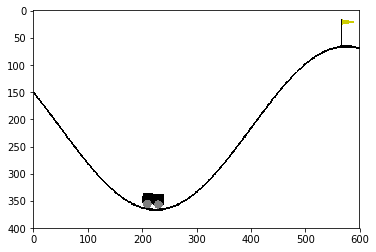

In [6]:
frame_player.display_frames_as_gif(frame, 60)